# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

In [34]:
def set_seed(seed):
    # fix seed
    import numpy as np
    np.random.seed(seed)
    import torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import random
    random.seed(seed)
set_seed(23)

FLAG = "train"
# FLAG = "eval"

# Libraries

In [35]:
!nvidia-smi # Run this to see what GPU you have

Sun Mar  9 11:00:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:41:00.0 Off |                    0 |
| N/A   31C    P0             62W /  300W |   10863MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

!pip install torchsummary
!pip install pandas
!pip install matplotlib

TODO: Change Imports based on new dataset

In [36]:
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


# Kaggle

In [37]:
# # Reminder: Make sure you have connected your kaggle API before running this block
# !mkdir '/content/data'

# !kaggle competitions download -c 11785-hw-2-p-2-face-verification-spring-2025 

# Config

In [38]:
config = {
    'batch_size': 4196, # Increase this if your GPU can handle it
    'lr': 0.001,
    'epochs': 150, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'cls_data_dir': "./data/HW2p2_S25/cls_data", #TODO: Provide path of classification directory
    'ver_data_dir': "./data/HW2p2_S25/ver_data", #TODO: Provide path of verification directory
    'val_pairs_file': "./data/HW2p2_S25/val_pairs.txt", #TODO: Provide path of text file containing val pairs for verification
    'test_pairs_file': "./data/HW2p2_S25/test_pairs.txt", #TODO: Provide path of text file containing test pairs for verification
    'checkpoint_dir': "./ckpt", #TODO: Checkpoint directory
    'augument': False, 
    'label_smoothing': 0.1, 
    # Include other parameters as needed.
}

# Dataset

In [39]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        # T.ToDtype(torch.float32, scale=True),
        T.ConvertImageDtype(torch.float32), # NOTE: v2 not available
        
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # Example:
        transform_list.extend([
            T.RandomHorizontalFlip(),
            T.RandomRotation(degrees=15),
            T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        ])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


## Classification Datasets and Dataloaders

In [40]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

20

In [41]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=False)

In [42]:
# Datasets
cls_train_dataset = ImageDataset(root=f"{config['cls_data_dir']}/train", transform=train_transforms, num_classes=config['num_classes'])
cls_val_dataset   = ImageDataset(root=f"{config['cls_data_dir']}/dev", transform=val_transforms, num_classes=config['num_classes'])
cls_test_dataset  = ImageDataset(root=f"{config['cls_data_dir']}/test", transform=val_transforms, num_classes=config['num_classes'])

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"


# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 43155/43155 [00:00<00:00, 744865.06it/s]


## Verification Dataset and Datatloaders

In [43]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [44]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [45]:
# Datasets
ver_val_dataset = ImagePairDataset(root=config['ver_data_dir'], pairs_file=config['val_pairs_file'], transform=val_transforms)
ver_test_dataset = TestImagePairDataset(root=config['ver_data_dir'], pairs_file=config['test_pairs_file'], transform=val_transforms)

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)


Loading image pairs: 100%|██████████| 6000/6000 [00:02<00:00, 2125.61it/s]


## Create Dataloaders for Image Recognition

# EDA and Viz

In [46]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  4196
Train batches        :  103
Val batches          :  11


### Classification Dataset Viz

def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

### Ver Dataset Viz

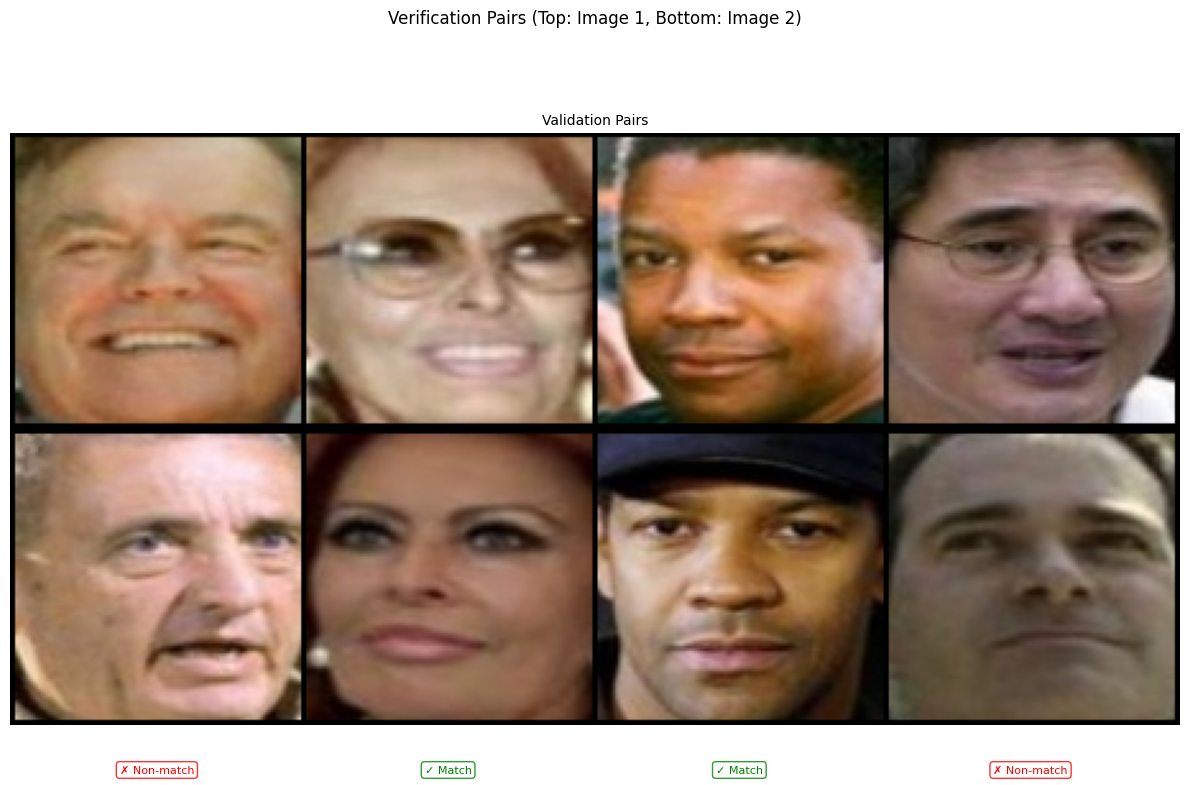

In [47]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

# TODO: Fill out the model definition below

class Network(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.backbone = torch.nn.Sequential(

            # TODO

            )

        self.cls_layer = #TODO

    def forward(self, x):

        feats = self.backbone(x)
        out = self.cls_layer(feats)

        return {"feats": feats, "out": out}

# Initialize your model
model = Network(num_classes=config['num_classes']).to(DEVICE)
summary(model, (3, 112, 112))

import torch
import torch.nn as nn
from torchvision import models
from torch.hub import load_state_dict_from_url
!pwd

class ResNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnet18()
        resnet.load_state_dict(torch.load("./resnet18/resnet.pth"))

        # resnet = models.resnet18(pretrained=True)

        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.cls_layer = nn.Linear(512, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        feats = feats.view(feats.size(0), -1)
        out = self.cls_layer(feats)
        return {"feats": feats, "out": out}

# model = ResNetwork(num_classes=config['num_classes']).to(DEVICE)
summary(model, (3, 112, 112))

In [48]:
import torch
import torch.nn as nn
from torchvision import models
from torch.hub import load_state_dict_from_url

from convnext_model import convnext_785
model = convnext_785(num_classes=config['num_classes']).to(DEVICE)
# summary(model, (3, 112, 112))

# --------------------------------------------------- #

# Defining Loss function
criterion = # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer =  # TODO: Feel free to pick a optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = None# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

In [49]:
import torch
import torch.nn.functional as F

def smooth_labels(labels, classes, smoothing=0.1):
    """
    Apply label smoothing to one-hot encoded labels.
    
    labels: Tensor of shape (batch_size,)
    classes: Total number of classes
    smoothing: Smoothing factor (0 means no smoothing)
    """
    confidence = 1.0 - smoothing
    smooth_value = smoothing / (classes - 1)

    one_hot = torch.full((labels.size(0), classes), smooth_value).to(labels.device)
    one_hot.scatter_(1, labels.unsqueeze(1), confidence)
    
    return one_hot

class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, label_smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = label_smoothing

    def forward(self, preds, target):
        classes = preds.size(1)  # Number of classes
        smoothed_targets = smooth_labels(target, classes, self.smoothing)
        log_probs = F.log_softmax(preds, dim=-1)
        return torch.mean(torch.sum(-smoothed_targets * log_probs, dim=-1))

class LabelSmoothingCrossEntropyWithArcFace(torch.nn.Module):
    def __init__(self, label_smoothing=0.1, arc_face_weights=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = label_smoothing
        self.arc_face_weights = arc_face_weights
    
    def forward(self, preds, target):
        '''
        Implement the cross entropy loss function with label smoothing and arc face margin loss.
        '''

In [50]:
# Defining Loss function
# criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = LabelSmoothingCrossEntropy(label_smoothing=config['label_smoothing'])

# TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
# TODO: Feel free to pick a optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Metrics

In [51]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [52]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [53]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [54]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)
            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [55]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [56]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [57]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        # with torch.inference_mode():
        with torch.no_grad():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [58]:
wandb.login(key="4dd2f46439865db4e3547d39c268ff46468b8ef4") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [59]:
# Create your wandb run
run = wandb.init(
    name = "0308", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

## Disable WandB

run = None

# Checkpointing and Loading Model

In [60]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [61]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [29]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
if FLAG == "eval":
    load_model(model, optimizer=None, scheduler=None, path='/home/xly/11785/hw2p2/ckpt/best_cls.pth')
if FLAG == "train":
    for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                # NOTE: don't save model on wandb!
                # wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            # NOTE: don't save model on wandb
            # wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/150



Epoch 1/150: 
Train Cls. Acc 0.1067%	 Train Cls. Loss 8.7338	 Learning Rate 0.0010


Val Cls. Acc 0.3316%	 Val Cls. Loss 8.3443


{'ACC': 75.2, 'EER': 25.147347740752878, 'AUC': 81.47239705664634, 'TPRs': [('TPR@FPR=1e-4', 0.20366598778004072), ('TPR@FPR=5e-4', 0.20366598778004072), ('TPR@FPR=1e-3', 0.20366598778004072), ('TPR@FPR=5e-3', 4.480651731160896), ('TPR@FPR=5e-2', 38.289205702647656)]}
Val Ret. Acc 75.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 2/150



Epoch 2/150: 
Train Cls. Acc 1.0206%	 Train Cls. Loss 7.9828	 Learning Rate 0.0010


Val Cls. Acc 2.2271%	 Val Cls. Loss 7.6441


{'ACC': 81.4, 'EER': 19.551934826882377, 'AUC': 88.01571709233792, 'TPRs': [('TPR@FPR=1e-4', 6.313645621181263), ('TPR@FPR=5e-4', 6.313645621181263), ('TPR@FPR=1e-3', 6.313645621181263), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 81.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/150



Epoch 3/150: 
Train Cls. Acc 4.1157%	 Train Cls. Loss 7.2800	 Learning Rate 0.0010


Val Cls. Acc 6.1634%	 Val Cls. Loss 7.0261


{'ACC': 84.1, 'EER': 16.700610997963338, 'AUC': 91.47483784746258, 'TPRs': [('TPR@FPR=1e-4', 27.698574338085542), ('TPR@FPR=5e-4', 27.698574338085542), ('TPR@FPR=1e-3', 27.698574338085542), ('TPR@FPR=5e-3', 38.4928716904277), ('TPR@FPR=5e-2', 65.37678207739307)]}
Val Ret. Acc 84.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/150



Epoch 4/150: 
Train Cls. Acc 9.9178%	 Train Cls. Loss 6.6323	 Learning Rate 0.0010


Val Cls. Acc 11.8960%	 Val Cls. Loss 6.4861


{'ACC': 85.4, 'EER': 15.682281059063138, 'AUC': 93.07015473013256, 'TPRs': [('TPR@FPR=1e-4', 41.34419551934827), ('TPR@FPR=5e-4', 41.34419551934827), ('TPR@FPR=1e-3', 41.34419551934827), ('TPR@FPR=5e-3', 43.9918533604888), ('TPR@FPR=5e-2', 70.26476578411406)]}
Val Ret. Acc 85.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/150



Epoch 5/150: 
Train Cls. Acc 17.9580%	 Train Cls. Loss 5.9991	 Learning Rate 0.0010


Val Cls. Acc 18.7267%	 Val Cls. Loss 5.9400


{'ACC': 87.0, 'EER': 13.849287169041569, 'AUC': 93.55711250445144, 'TPRs': [('TPR@FPR=1e-4', 53.56415478615071), ('TPR@FPR=5e-4', 53.56415478615071), ('TPR@FPR=1e-3', 53.56415478615071), ('TPR@FPR=5e-3', 57.841140529531565), ('TPR@FPR=5e-2', 75.76374745417516)]}
Val Ret. Acc 87.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/150



Epoch 6/150: 
Train Cls. Acc 26.8100%	 Train Cls. Loss 5.4058	 Learning Rate 0.0010


Val Cls. Acc 25.1308%	 Val Cls. Loss 5.5126


{'ACC': 87.5, 'EER': 14.052953156832281, 'AUC': 93.26541799543052, 'TPRs': [('TPR@FPR=1e-4', 28.716904276985744), ('TPR@FPR=5e-4', 28.716904276985744), ('TPR@FPR=1e-3', 28.716904276985744), ('TPR@FPR=5e-3', 68.22810590631364), ('TPR@FPR=5e-2', 75.96741344195519)]}
Val Ret. Acc 87.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/150



Epoch 7/150: 
Train Cls. Acc 35.2378%	 Train Cls. Loss 4.8928	 Learning Rate 0.0010


Val Cls. Acc 31.6343%	 Val Cls. Loss 5.1240


{'ACC': 88.2, 'EER': 12.016293279022282, 'AUC': 94.32496128745713, 'TPRs': [('TPR@FPR=1e-4', 43.17718940936864), ('TPR@FPR=5e-4', 43.17718940936864), ('TPR@FPR=1e-3', 43.17718940936864), ('TPR@FPR=5e-3', 63.13645621181263), ('TPR@FPR=5e-2', 79.0224032586558)]}
Val Ret. Acc 88.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/150



Epoch 8/150: 
Train Cls. Acc 42.8057%	 Train Cls. Loss 4.4606	 Learning Rate 0.0010


Val Cls. Acc 36.8048%	 Val Cls. Loss 4.8266


{'ACC': 88.2, 'EER': 12.219959266848177, 'AUC': 94.33576478779125, 'TPRs': [('TPR@FPR=1e-4', 44.806517311608964), ('TPR@FPR=5e-4', 44.806517311608964), ('TPR@FPR=1e-3', 44.806517311608964), ('TPR@FPR=5e-3', 58.85947046843177), ('TPR@FPR=5e-2', 80.44806517311609)]}
Val Ret. Acc 88.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/150



Epoch 9/150: 
Train Cls. Acc 49.7539%	 Train Cls. Loss 4.0880	 Learning Rate 0.0010


Val Cls. Acc 40.7786%	 Val Cls. Loss 4.5930


{'ACC': 88.4, 'EER': 12.770137524465417, 'AUC': 94.40978877156198, 'TPRs': [('TPR@FPR=1e-4', 49.287169042769854), ('TPR@FPR=5e-4', 49.287169042769854), ('TPR@FPR=1e-3', 49.287169042769854), ('TPR@FPR=5e-3', 62.52545824847251), ('TPR@FPR=5e-2', 80.04073319755601)]}
Val Ret. Acc 88.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/150



Epoch 10/150: 
Train Cls. Acc 55.7808%	 Train Cls. Loss 3.7805	 Learning Rate 0.0010


Val Cls. Acc 44.0175%	 Val Cls. Loss 4.4148


{'ACC': 90.3, 'EER': 10.59063136457548, 'AUC': 94.99357791924584, 'TPRs': [('TPR@FPR=1e-4', 46.435845213849284), ('TPR@FPR=5e-4', 46.435845213849284), ('TPR@FPR=1e-3', 46.435845213849284), ('TPR@FPR=5e-3', 63.34012219959266), ('TPR@FPR=5e-2', 82.68839103869654)]}
Val Ret. Acc 90.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 11/150



Epoch 11/150: 
Train Cls. Acc 61.1062%	 Train Cls. Loss 3.5164	 Learning Rate 0.0010


Val Cls. Acc 46.5162%	 Val Cls. Loss 4.2835


{'ACC': 90.6, 'EER': 9.572301425661864, 'AUC': 95.04159347628631, 'TPRs': [('TPR@FPR=1e-4', 56.0081466395112), ('TPR@FPR=5e-4', 56.0081466395112), ('TPR@FPR=1e-3', 56.0081466395112), ('TPR@FPR=5e-3', 64.15478615071282), ('TPR@FPR=5e-2', 79.83706720977597)]}
Val Ret. Acc 90.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/150



Epoch 12/150: 
Train Cls. Acc 65.8788%	 Train Cls. Loss 3.2902	 Learning Rate 0.0010


Val Cls. Acc 48.9872%	 Val Cls. Loss 4.1465


{'ACC': 90.1, 'EER': 10.8055009823968, 'AUC': 94.82632372888816, 'TPRs': [('TPR@FPR=1e-4', 46.84317718940937), ('TPR@FPR=5e-4', 46.84317718940937), ('TPR@FPR=1e-3', 46.84317718940937), ('TPR@FPR=5e-3', 58.65580448065173), ('TPR@FPR=5e-2', 82.07739307535643)]}
Val Ret. Acc 90.1000%
Saved epoch model
Saved best classification model

Epoch 13/150



Epoch 13/150: 
Train Cls. Acc 70.2145%	 Train Cls. Loss 3.0982	 Learning Rate 0.0010


Val Cls. Acc 50.5170%	 Val Cls. Loss 4.0709


{'ACC': 89.7, 'EER': 10.609037327989833, 'AUC': 94.76630428258756, 'TPRs': [('TPR@FPR=1e-4', 50.71283095723014), ('TPR@FPR=5e-4', 50.71283095723014), ('TPR@FPR=1e-3', 50.71283095723014), ('TPR@FPR=5e-3', 61.91446028513238), ('TPR@FPR=5e-2', 79.83706720977597)]}
Val Ret. Acc 89.7000%
Saved epoch model
Saved best classification model

Epoch 14/150



Epoch 14/150: 
Train Cls. Acc 74.0222%	 Train Cls. Loss 2.9259	 Learning Rate 0.0010


Val Cls. Acc 51.4054%	 Val Cls. Loss 4.0187


{'ACC': 89.4, 'EER': 10.997963340122029, 'AUC': 94.84352930349435, 'TPRs': [('TPR@FPR=1e-4', 54.78615071283096), ('TPR@FPR=5e-4', 54.78615071283096), ('TPR@FPR=1e-3', 54.78615071283096), ('TPR@FPR=5e-3', 59.67413441955194), ('TPR@FPR=5e-2', 82.28105906313645)]}
Val Ret. Acc 89.4000%
Saved epoch model
Saved best classification model

Epoch 15/150



Epoch 15/150: 
Train Cls. Acc 77.4160%	 Train Cls. Loss 2.7803	 Learning Rate 0.0010


Val Cls. Acc 52.5822%	 Val Cls. Loss 3.9653


{'ACC': 89.3, 'EER': 11.3948919449305, 'AUC': 94.86713695237256, 'TPRs': [('TPR@FPR=1e-4', 53.360488798370675), ('TPR@FPR=5e-4', 53.360488798370675), ('TPR@FPR=1e-3', 53.360488798370675), ('TPR@FPR=5e-3', 65.17311608961303), ('TPR@FPR=5e-2', 81.05906313645622)]}
Val Ret. Acc 89.3000%
Saved epoch model
Saved best classification model

Epoch 16/150



Epoch 16/150: 
Train Cls. Acc 80.7279%	 Train Cls. Loss 2.6447	 Learning Rate 0.0010


Val Cls. Acc 53.3904%	 Val Cls. Loss 3.9298


{'ACC': 88.9, 'EER': 11.787819253510785, 'AUC': 94.55983738731348, 'TPRs': [('TPR@FPR=1e-4', 58.044806517311606), ('TPR@FPR=5e-4', 58.044806517311606), ('TPR@FPR=1e-3', 58.044806517311606), ('TPR@FPR=5e-3', 62.729124236252545), ('TPR@FPR=5e-2', 80.44806517311609)]}
Val Ret. Acc 88.9000%
Saved epoch model
Saved best classification model

Epoch 17/150



Epoch 17/150: 
Train Cls. Acc 83.6318%	 Train Cls. Loss 2.5274	 Learning Rate 0.0010


Val Cls. Acc 53.6790%	 Val Cls. Loss 3.9162


{'ACC': 88.7, 'EER': 12.573673870324836, 'AUC': 94.76950531972359, 'TPRs': [('TPR@FPR=1e-4', 64.15478615071282), ('TPR@FPR=5e-4', 64.15478615071282), ('TPR@FPR=1e-3', 64.15478615071282), ('TPR@FPR=5e-3', 68.43177189409369), ('TPR@FPR=5e-2', 81.26272912423626)]}
Val Ret. Acc 88.7000%
Saved epoch model
Saved best classification model

Epoch 18/150



Epoch 18/150: 
Train Cls. Acc 86.3489%	 Train Cls. Loss 2.4220	 Learning Rate 0.0010


Val Cls. Acc 53.8044%	 Val Cls. Loss 3.9027


{'ACC': 88.7, 'EER': 12.180746561738431, 'AUC': 94.54943401662139, 'TPRs': [('TPR@FPR=1e-4', 58.248472505091655), ('TPR@FPR=5e-4', 58.248472505091655), ('TPR@FPR=1e-3', 58.248472505091655), ('TPR@FPR=5e-3', 62.93279022403259), ('TPR@FPR=5e-2', 80.44806517311609)]}
Val Ret. Acc 88.7000%
Saved epoch model
Saved best classification model

Epoch 19/150



Epoch 19/150: 
Train Cls. Acc 88.7620%	 Train Cls. Loss 2.3284	 Learning Rate 0.0010


Val Cls. Acc 53.7404%	 Val Cls. Loss 3.9066


{'ACC': 89.3, 'EER': 11.812627291235257, 'AUC': 94.73469404086924, 'TPRs': [('TPR@FPR=1e-4', 56.61914460285132), ('TPR@FPR=5e-4', 56.61914460285132), ('TPR@FPR=1e-3', 56.61914460285132), ('TPR@FPR=5e-3', 63.543788187372705), ('TPR@FPR=5e-2', 81.05906313645622)]}
Val Ret. Acc 89.3000%
Saved epoch model

Epoch 20/150



Epoch 20/150: 
Train Cls. Acc 91.0597%	 Train Cls. Loss 2.2418	 Learning Rate 0.0010


Val Cls. Acc 54.2658%	 Val Cls. Loss 3.8846


{'ACC': 88.3, 'EER': 12.423625254594503, 'AUC': 94.37217658521362, 'TPRs': [('TPR@FPR=1e-4', 61.099796334012225), ('TPR@FPR=5e-4', 61.099796334012225), ('TPR@FPR=1e-3', 61.099796334012225), ('TPR@FPR=5e-3', 63.34012219959266), ('TPR@FPR=5e-2', 79.22606924643586)]}
Val Ret. Acc 88.3000%
Saved epoch model
Saved best classification model

Epoch 21/150



Epoch 21/150: 
Train Cls. Acc 92.9668%	 Train Cls. Loss 2.1657	 Learning Rate 0.0010


Val Cls. Acc 54.3299%	 Val Cls. Loss 3.8935


{'ACC': 89.0, 'EER': 11.591355599215253, 'AUC': 94.3717764555716, 'TPRs': [('TPR@FPR=1e-4', 62.52545824847251), ('TPR@FPR=5e-4', 62.52545824847251), ('TPR@FPR=1e-3', 62.52545824847251), ('TPR@FPR=5e-3', 67.41344195519349), ('TPR@FPR=5e-2', 79.22606924643586)]}
Val Ret. Acc 89.0000%
Saved epoch model
Saved best classification model

Epoch 22/150



Epoch 22/150: 
Train Cls. Acc 94.6477%	 Train Cls. Loss 2.1001	 Learning Rate 0.0010


Val Cls. Acc 54.1966%	 Val Cls. Loss 3.8950


{'ACC': 88.7, 'EER': 12.423625254582475, 'AUC': 93.78758717824576, 'TPRs': [('TPR@FPR=1e-4', 54.78615071283096), ('TPR@FPR=5e-4', 54.78615071283096), ('TPR@FPR=1e-3', 54.78615071283096), ('TPR@FPR=5e-3', 62.729124236252545), ('TPR@FPR=5e-2', 80.85539714867616)]}
Val Ret. Acc 88.7000%
Saved epoch model

Epoch 23/150



Epoch 23/150: 
Train Cls. Acc 96.0530%	 Train Cls. Loss 2.0390	 Learning Rate 0.0010


Val Cls. Acc 54.7362%	 Val Cls. Loss 3.8828


{'ACC': 88.3, 'EER': 12.830957230142573, 'AUC': 93.49869357671888, 'TPRs': [('TPR@FPR=1e-4', 61.5071283095723), ('TPR@FPR=5e-4', 61.5071283095723), ('TPR@FPR=1e-3', 61.5071283095723), ('TPR@FPR=5e-3', 64.56211812627292), ('TPR@FPR=5e-2', 79.63340122199592)]}
Val Ret. Acc 88.3000%
Saved epoch model
Saved best classification model

Epoch 24/150



Epoch 24/150: 
Train Cls. Acc 97.2589%	 Train Cls. Loss 1.9841	 Learning Rate 0.0010


Val Cls. Acc 54.8438%	 Val Cls. Loss 3.8820


{'ACC': 87.7, 'EER': 12.770137524577352, 'AUC': 93.38705740659975, 'TPRs': [('TPR@FPR=1e-4', 57.23014256619145), ('TPR@FPR=5e-4', 57.23014256619145), ('TPR@FPR=1e-3', 57.23014256619145), ('TPR@FPR=5e-3', 61.099796334012225), ('TPR@FPR=5e-2', 77.39307535641548)]}
Val Ret. Acc 87.7000%
Saved epoch model
Saved best classification model

Epoch 25/150



Epoch 25/150: 
Train Cls. Acc 98.1308%	 Train Cls. Loss 1.9410	 Learning Rate 0.0010


Val Cls. Acc 54.7298%	 Val Cls. Loss 3.8797


{'ACC': 87.4, 'EER': 13.752455795622836, 'AUC': 93.08615991581271, 'TPRs': [('TPR@FPR=1e-4', 55.397148676171085), ('TPR@FPR=5e-4', 55.397148676171085), ('TPR@FPR=1e-3', 55.397148676171085), ('TPR@FPR=5e-3', 57.43380855397149), ('TPR@FPR=5e-2', 78.00407331975559)]}
Val Ret. Acc 87.4000%
Saved epoch model

Epoch 26/150



Epoch 26/150: 
Train Cls. Acc 98.7863%	 Train Cls. Loss 1.8993	 Learning Rate 0.0010


Val Cls. Acc 55.0257%	 Val Cls. Loss 3.8802


{'ACC': 87.7, 'EER': 13.238289205702609, 'AUC': 92.92970922578915, 'TPRs': [('TPR@FPR=1e-4', 52.54582484725051), ('TPR@FPR=5e-4', 52.54582484725051), ('TPR@FPR=1e-3', 52.54582484725051), ('TPR@FPR=5e-3', 58.044806517311606), ('TPR@FPR=5e-2', 77.18940936863544)]}
Val Ret. Acc 87.7000%
Saved epoch model
Saved best classification model

Epoch 27/150



Epoch 27/150: 
Train Cls. Acc 99.2315%	 Train Cls. Loss 1.8641	 Learning Rate 0.0010


Val Cls. Acc 55.1156%	 Val Cls. Loss 3.8851


{'ACC': 85.6, 'EER': 14.931237721069628, 'AUC': 91.52005249700903, 'TPRs': [('TPR@FPR=1e-4', 48.26883910386965), ('TPR@FPR=5e-4', 48.26883910386965), ('TPR@FPR=1e-3', 48.26883910386965), ('TPR@FPR=5e-3', 56.211812627291245), ('TPR@FPR=5e-2', 72.50509164969449)]}
Val Ret. Acc 85.6000%
Saved epoch model
Saved best classification model

Epoch 28/150



Epoch 28/150: 
Train Cls. Acc 99.5018%	 Train Cls. Loss 1.8370	 Learning Rate 0.0010


Val Cls. Acc 55.2075%	 Val Cls. Loss 3.8718


{'ACC': 86.4, 'EER': 14.256619144584128, 'AUC': 91.66289877920445, 'TPRs': [('TPR@FPR=1e-4', 45.621181262729124), ('TPR@FPR=5e-4', 45.621181262729124), ('TPR@FPR=1e-3', 45.621181262729124), ('TPR@FPR=5e-3', 57.0264765784114), ('TPR@FPR=5e-2', 73.93075356415478)]}
Val Ret. Acc 86.4000%
Saved epoch model
Saved best classification model

Epoch 29/150



Epoch 29/150: 
Train Cls. Acc 99.6802%	 Train Cls. Loss 1.8101	 Learning Rate 0.0009


Val Cls. Acc 55.5998%	 Val Cls. Loss 3.8552


{'ACC': 86.3, 'EER': 15.68228105906178, 'AUC': 91.27397276717656, 'TPRs': [('TPR@FPR=1e-4', 40.52953156822811), ('TPR@FPR=5e-4', 40.52953156822811), ('TPR@FPR=1e-3', 40.52953156822811), ('TPR@FPR=5e-3', 56.0081466395112), ('TPR@FPR=5e-2', 73.5234215885947)]}
Val Ret. Acc 86.3000%
Saved epoch model
Saved best classification model

Epoch 30/150



Epoch 30/150: 
Train Cls. Acc 99.7964%	 Train Cls. Loss 1.7891	 Learning Rate 0.0009


Val Cls. Acc 55.5912%	 Val Cls. Loss 3.8562


{'ACC': 85.5, 'EER': 15.274949083503051, 'AUC': 90.97587618388359, 'TPRs': [('TPR@FPR=1e-4', 43.9918533604888), ('TPR@FPR=5e-4', 43.9918533604888), ('TPR@FPR=1e-3', 43.9918533604888), ('TPR@FPR=5e-3', 55.193482688391036), ('TPR@FPR=5e-2', 72.09775967413442)]}
Val Ret. Acc 85.5000%
Saved epoch model

Epoch 31/150



Epoch 31/150: 
Train Cls. Acc 99.8692%	 Train Cls. Loss 1.7707	 Learning Rate 0.0009


Val Cls. Acc 55.7807%	 Val Cls. Loss 3.8563


{'ACC': 84.6, 'EER': 16.699410609147407, 'AUC': 90.46411037176046, 'TPRs': [('TPR@FPR=1e-4', 46.435845213849284), ('TPR@FPR=5e-4', 46.435845213849284), ('TPR@FPR=1e-3', 46.435845213849284), ('TPR@FPR=5e-3', 48.676171079429736), ('TPR@FPR=5e-2', 71.28309572301426)]}
Val Ret. Acc 84.6000%
Saved epoch model
Saved best classification model

Epoch 32/150



Epoch 32/150: 
Train Cls. Acc 99.9181%	 Train Cls. Loss 1.7521	 Learning Rate 0.0009


Val Cls. Acc 55.8101%	 Val Cls. Loss 3.8480


{'ACC': 85.2, 'EER': 15.88594704684317, 'AUC': 90.58775043113968, 'TPRs': [('TPR@FPR=1e-4', 47.657841140529534), ('TPR@FPR=5e-4', 47.657841140529534), ('TPR@FPR=1e-3', 47.657841140529534), ('TPR@FPR=5e-3', 52.342158859470466), ('TPR@FPR=5e-2', 69.85743380855396)]}
Val Ret. Acc 85.2000%
Saved epoch model
Saved best classification model

Epoch 33/150



Epoch 33/150: 
Train Cls. Acc 99.9411%	 Train Cls. Loss 1.7380	 Learning Rate 0.0009


Val Cls. Acc 55.9890%	 Val Cls. Loss 3.8323


{'ACC': 84.7, 'EER': 16.699410608940045, 'AUC': 90.50532372488685, 'TPRs': [('TPR@FPR=1e-4', 43.17718940936864), ('TPR@FPR=5e-4', 43.17718940936864), ('TPR@FPR=1e-3', 43.17718940936864), ('TPR@FPR=5e-3', 52.342158859470466), ('TPR@FPR=5e-2', 71.28309572301426)]}
Val Ret. Acc 84.7000%
Saved epoch model
Saved best classification model

Epoch 34/150


Train:  90%|█████████ | 93/103 [01:51<00:11,  1.17s/it, acc=99.8570% (99.9652), loss=1.7547 (1.7204), lr=0.0009] 

# Test Kaggle Submission

In [30]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        # with torch.inference_mode():
        with torch.no_grad():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [31]:
scores = test_epoch_ver(model, ver_test_loader, config)

In [32]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-spring-2025 -f /content/verification_early_submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

/bin/bash: line 1: kaggle: command not found
